**Шубин Михаил, гр. 3825М1ПР1**

## **0. Описать задачу словами**

        Решается задача регрессии оценки "полезности" обзора игры/приложения в Steam на основании личных данных пользователя (количество игр/приложений на аккаунте, общее количество обзоров пользователя, время использования игры/приложения и т.д.), а также на основании реакций других пользователей на данный обзор (количество пользователей посчитавших обзор информативным и/или весёлым, количество комментариев под обзором).

## **1. Прочитать данные**

In [1]:
# Подключение модулей
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Загрузка датасета
raw_data = pd.read_csv("./Data/Steam_reviews_weighted_score_above_08.csv", low_memory=False)
raw_data = raw_data.drop(['recommendationid', 'appid', 'game', 'author_steamid', 'timestamp_created', 'timestamp_updated'], axis=1) # Удаление ID обзора, приложения и пользователя, названия приложения и дат создания и обновления обзора, поскольку они не имеют смыслового влияния на задачу
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498094 entries, 0 to 498093
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   author_num_games_owned          498094 non-null  int64  
 1   author_num_reviews              498094 non-null  int64  
 2   author_playtime_forever         498094 non-null  int64  
 3   author_playtime_last_two_weeks  498094 non-null  int64  
 4   author_playtime_at_review       498094 non-null  int64  
 5   author_last_played              498094 non-null  int64  
 6   language                        498094 non-null  object 
 7   review                          498094 non-null  object 
 8   voted_up                        498094 non-null  int64  
 9   votes_up                        498094 non-null  int64  
 10  votes_funny                     498094 non-null  int64  
 11  weighted_vote_score             498094 non-null  float64
 12  comment_count   

In [3]:
# Выделение числовых столбцов (кроме предсказываемого)
numeric_feat = set()
for feat in raw_data.keys():
  if ((raw_data.dtypes[feat] == 'float64' or raw_data.dtypes[feat] == 'int64') and feat != 'weighted_vote_score'):
    numeric_feat.add(feat)
binary_feat = set(['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'hidden_in_steam_china'])

numeric_feat

{'author_last_played',
 'author_num_games_owned',
 'author_num_reviews',
 'author_playtime_at_review',
 'author_playtime_forever',
 'author_playtime_last_two_weeks',
 'comment_count',
 'hidden_in_steam_china',
 'received_for_free',
 'steam_purchase',
 'voted_up',
 'votes_funny',
 'votes_up',
 'written_during_early_access'}

## **2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.)**

In [4]:
# Основные характеристики
raw_data.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china
count,498094.000000,498094.000000,4.980940e+05,498094.000000,4.980940e+05,4.980940e+05,498094.000000,498094.000000,4.980940e+05,498094.000000,498094.000000,498094.000000,498094.000000,498094.000000,498094.000000
mean,416.482487,54.545507,1.613352e+04,73.126382,8.185473e+03,1.533722e+09,0.844403,211.171807,1.731495e+04,0.862752,4.340179,0.692939,0.032827,0.119542,0.225564
std,1298.240833,202.719832,8.331352e+04,713.182725,4.557393e+04,3.917563e+08,0.362473,487.663438,8.606345e+06,0.045065,18.583549,0.461275,0.178184,0.324425,0.417954
min,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,2.740000e+02,0.000000,1.170000e+02,1.581068e+09,1.000000,65.000000,4.000000e+00,0.824808,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,13.000000,1.284000e+03,0.000000,5.990000e+02,1.650398e+09,1.000000,103.000000,1.400000e+01,0.854547,0.000000,1.000000,0.000000,0.000000,0.000000
75%,297.000000,37.000000,5.792000e+03,0.000000,2.609000e+03,1.685775e+09,1.000000,196.000000,5.200000e+01,0.894107,4.000000,1.000000,0.000000,0.000000,0.000000
max,30425.000000,10413.000000,5.839020e+06,20154.000000,4.776595e+06,1.699048e+09,1.000000,62199.000000,4.294967e+09,0.998141,4890.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Матрица корреляции
corr_data = raw_data.corr(numeric_only=True)
corr_data

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china
author_num_games_owned,1.000000,0.507958,-0.013965,-0.008095,-0.021300,-0.005819,0.015261,-0.020679,0.001305,-0.041553,0.023779,-0.090277,0.071461,-0.031980,-0.053924
author_num_reviews,0.507958,1.000000,-0.028640,-0.016243,-0.029632,-0.012595,0.011377,-0.034085,0.000878,-0.063886,0.006419,-0.086204,0.110993,-0.028228,-0.037748
author_playtime_forever,-0.013965,-0.028640,1.000000,0.526613,0.784932,0.068927,0.007750,0.021319,-0.000321,0.019007,0.076308,-0.038246,-0.005861,-0.012021,-0.028774
author_playtime_last_two_weeks,-0.008095,-0.016243,0.526613,1.000000,0.349687,0.043138,0.003247,0.014361,-0.000205,0.015290,0.022311,-0.014985,0.003609,-0.000896,0.053056
author_playtime_at_review,-0.021300,-0.029632,0.784932,0.349687,1.000000,0.061890,-0.010435,0.017346,-0.000238,0.015909,0.053302,-0.037665,-0.007150,-0.021749,0.004486
author_last_played,-0.005819,-0.012595,0.068927,0.043138,0.061890,1.000000,0.090679,0.027393,-0.000150,0.020335,0.018926,-0.043937,0.011283,0.100874,0.094810
voted_up,0.015261,0.011377,0.007750,0.003247,-0.010435,0.090679,1.000000,-0.087294,0.000861,0.059359,-0.068890,0.040936,0.013620,0.001617,-0.031836
votes_up,-0.020679,-0.034085,0.021319,0.014361,0.017346,0.027393,-0.087294,1.000000,-0.000617,0.338506,0.387863,-0.000909,-0.003911,0.012579,0.021511
votes_funny,0.001305,0.000878,-0.000321,-0.000205,-0.000238,-0.000150,0.000861,-0.000617,1.000000,-0.001904,0.000078,0.001334,-0.000369,-0.000738,-0.001083
weighted_vote_score,-0.041553,-0.063886,0.019007,0.015290,0.015909,0.020335,0.059359,0.338506,-0.001904,1.000000,0.116434,0.031681,-0.021930,0.009623,0.019446


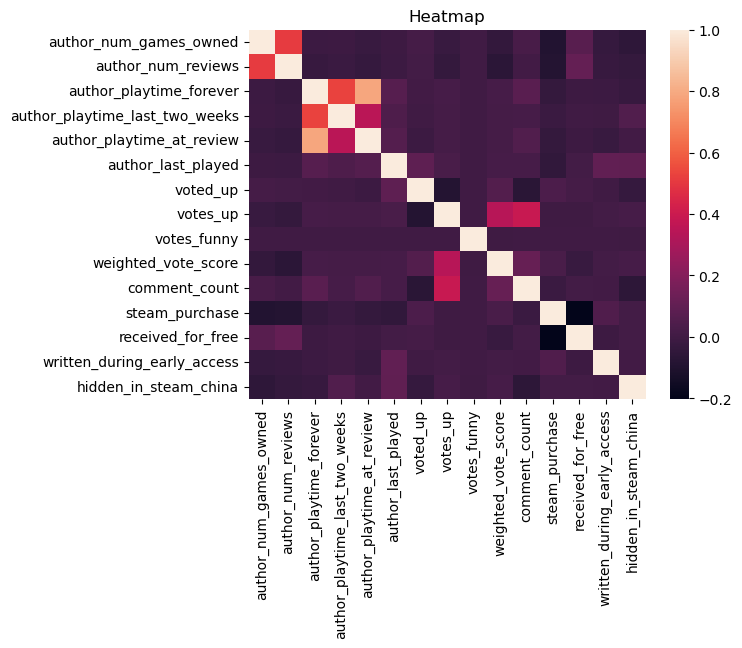

In [6]:
# Матрица корреляции в виде карты тепла
ax = sns.heatmap(corr_data)
ax.set_title("Heatmap")
plt.show()

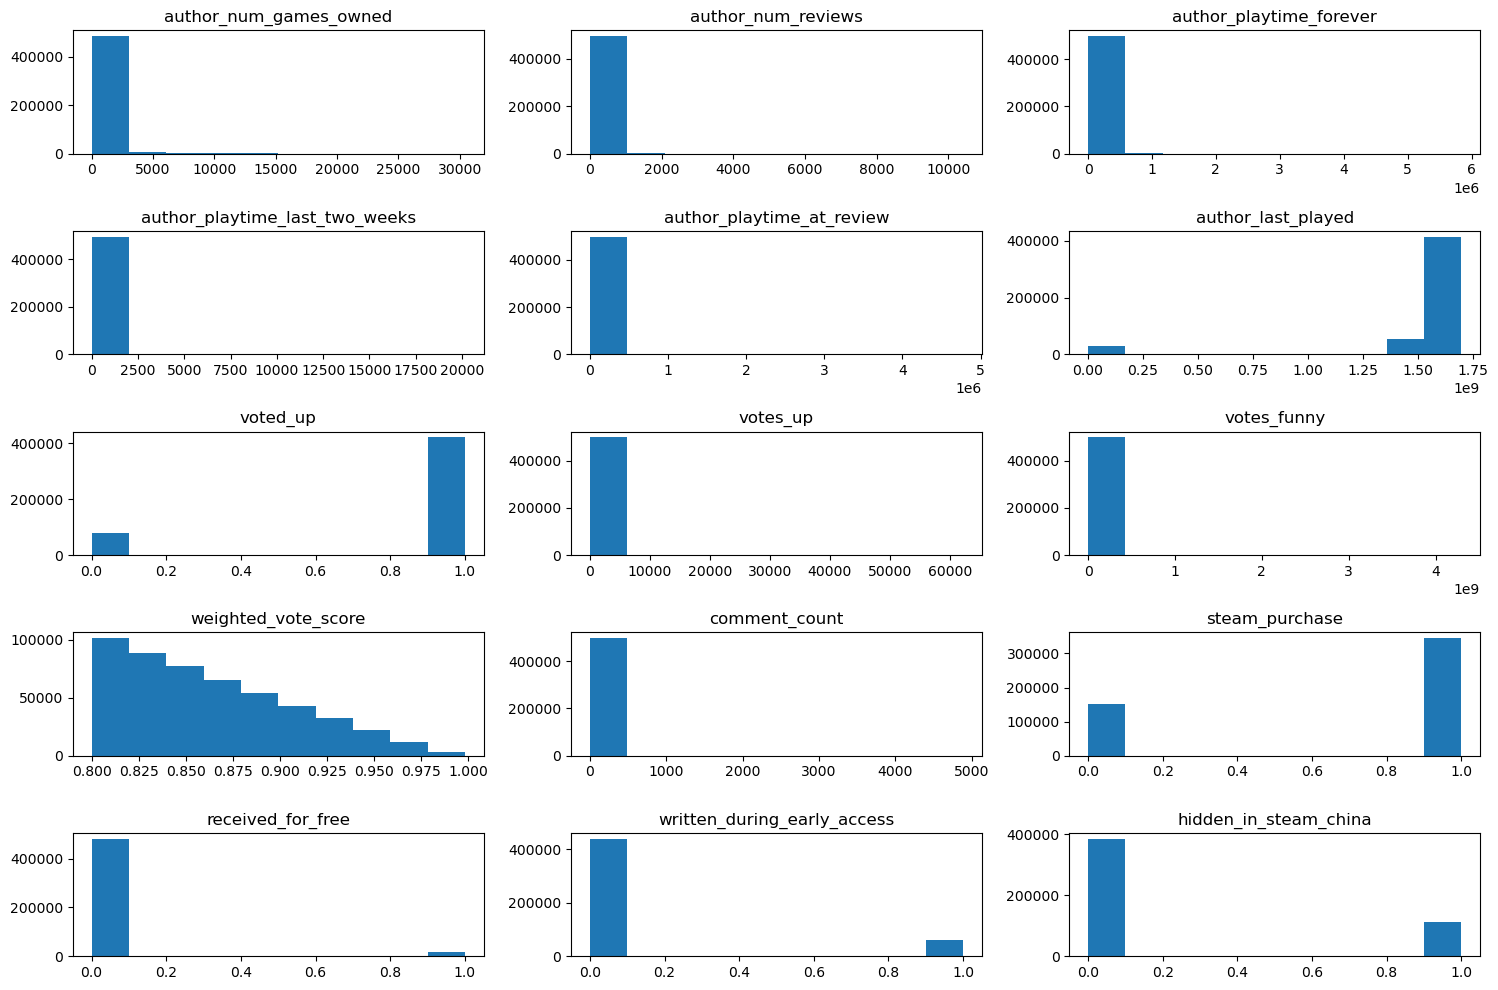

In [7]:
# Гистограммы численных столбцов
raw_data.hist(grid=False, layout=(5, 3), figsize=(15, 10))
plt.tight_layout()
plt.show()

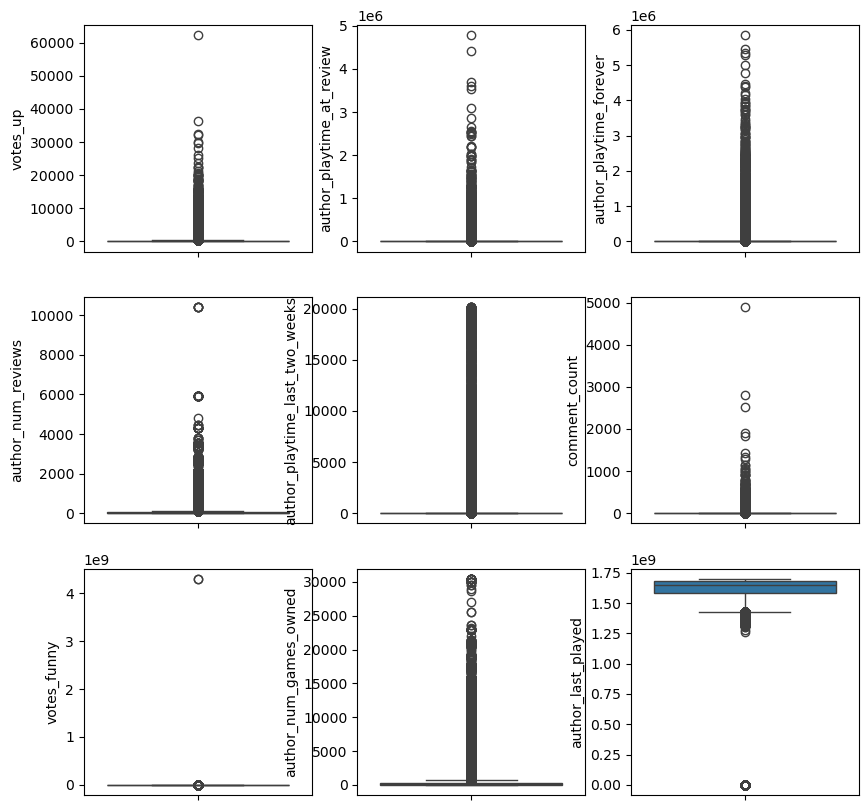

In [8]:
# Boxplot'ы исходных численных данных
for_use_data = raw_data

f, axes = plt.subplots(3, 3)
f.set_figheight(10)
f.set_figwidth(10)

k = 0
for feat in numeric_feat:
  if feat not in binary_feat:
    sns.boxplot(raw_data[feat], ax=axes[k//3, k%3])
    k += 1

plt.show()

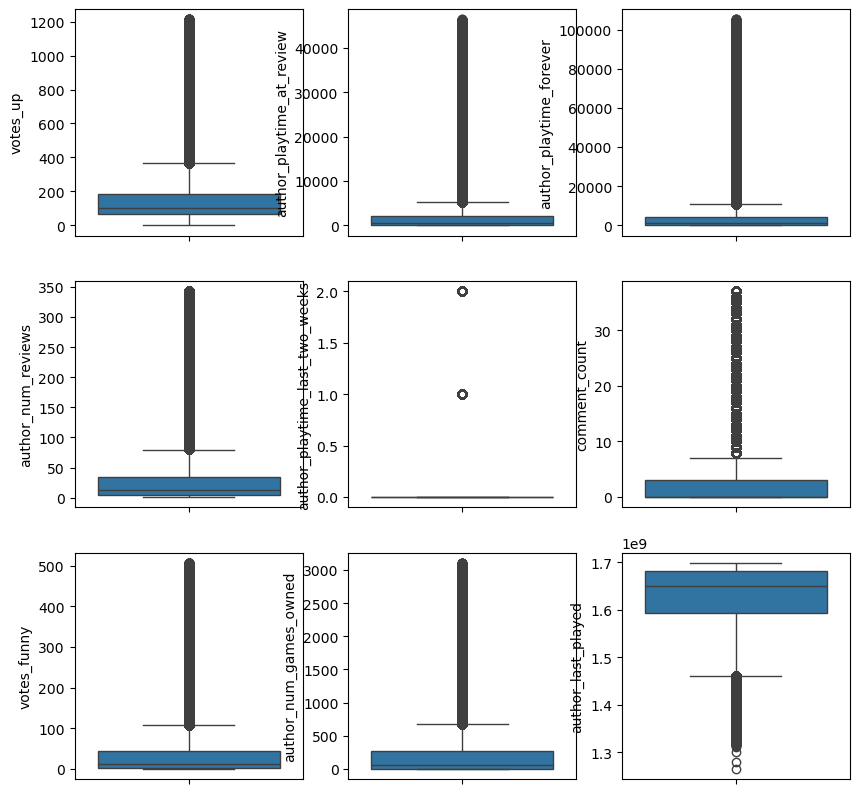

In [9]:
# "Обработанное представление" численных данных (отбрасываем только там, где есть большие отклонения)
for_use_data = raw_data

f, axes = plt.subplots(3, 3)
f.set_figheight(10)
f.set_figwidth(10)

# Подобраны вручную, чтобы уменьшить количество выбросов, но при этом не удалить все значения в таблице (происходит из-за столбца author_playtime_last_two_weeks)
ql_lvl = 0.072
qu_lvl = 0.928
k = 0
for feat in numeric_feat:
  if feat not in binary_feat:
    ql, qu = raw_data[feat].quantile([ql_lvl, qu_lvl])
    iqr = qu - ql
    for_use_data = for_use_data[for_use_data[feat] < qu + 1.5*iqr]
    for_use_data = for_use_data[for_use_data[feat] > ql - 1.5*iqr]
    sns.boxplot(for_use_data[feat], ax=axes[k//3, k%3])
    k += 1

plt.show()

In [10]:
print("Исходное число записей:", len(raw_data['author_num_games_owned']))
print("Число записи после удаления выбросов:", len(for_use_data['author_num_games_owned']))

Исходное число записей: 498094
Число записи после удаления выбросов: 382132


**Основные наблюдения:**

    1) Наблюдается большой разброс в столбцах author_num_games_owned (количество игр на аккаунте), author_playtime_... (время игры) и votes_funny (число пользователей, посчитавших обзор забавным).
    2) Между переменными author_num_games_owned (количество игр на аккаунте) и author_num_reviews (количество обзоров, написанных аккаунтом), а также между votes_up (число пользователей, посчитавших обзор полезным), comment_count (количество комментариев под обзором) и weighted_vote_score ("полезность" обзора) заметна умеренная зависимость. Поскольку смысловая нагрузка переменных сильно отличается, отбрасывать данные переменные не имеет смысла.
    3) Между переменными author_playtime_forever (общее время игры) и author_playtime_at_review (время игры на момент написания обзора) видна сильная зависимость. Поскольку в смысловом плане эти переменные крайне похожи, последняя будет отброшена. Переменная author_playtime_last_two_weeks (время игры за последние две недели) имеет с author_playtime_forever умеренную зависимость, однако, в отличие от пункта 2, имеет смысл отбросить её, поскольку её смысловая нагрузка очень схожа с author_playtime_forever. Удаление сильно коррелированных переменных позволяет избежать мультиколлинеарности, а также снизить эффекты переобучения.
    4) Остальные переменные коррелированы друг с другом слабо.

In [11]:
for_use_data = for_use_data.drop(['author_playtime_last_two_weeks', 'author_playtime_at_review'], axis=1)
numeric_feat.remove('author_playtime_last_two_weeks')
numeric_feat.remove('author_playtime_at_review')

## **3. Обработать пропущенные значения**

In [12]:
print("Пропущенные значения в исходных данных:")
raw_data.isna().sum()

Пропущенные значения в исходных данных:


author_num_games_owned                 0
author_num_reviews                     0
author_playtime_forever                0
author_playtime_last_two_weeks         0
author_playtime_at_review              0
author_last_played                     0
language                               0
review                                 0
voted_up                               0
votes_up                               0
votes_funny                            0
weighted_vote_score                    0
comment_count                          0
steam_purchase                         0
received_for_free                      0
written_during_early_access            0
hidden_in_steam_china                  0
steam_china_location              498072
dtype: int64

Пропущенные значения встречаются в одном столбце, при этом непустых значений гораздо меньше, чем пустых. Данный столбец имеет строковый тип, поэтому заменить средними/медианными значениями не получится. В смысловом плане данный признак не должен влиять на "полезность" обзора (судить о полезности обзора на основании региона Китая, в котором доступно приложение, кажется некорректно), поэтому отбросим данный столбец.

In [13]:
for_use_data = for_use_data.drop(['steam_china_location'], axis=1)

In [14]:
print("Пропущенные значения после обработки:")
for_use_data.isna().sum()

Пропущенные значения после обработки:


author_num_games_owned         0
author_num_reviews             0
author_playtime_forever        0
author_last_played             0
language                       0
review                         0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
hidden_in_steam_china          0
dtype: int64

## **4. Обработать категориальные признаки**

Имеется один категориальный признак: язык обзора.

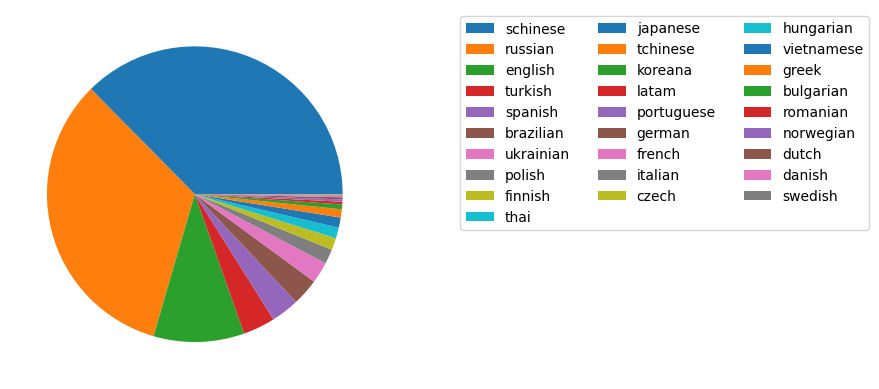

In [15]:
plt.pie(for_use_data['language'].value_counts().values)
languages = list(for_use_data['language'].unique())
plt.legend(ncol=3, bbox_to_anchor=(1.2, 1), labels = languages)
plt.show()

In [16]:
for_use_data = pd.concat((for_use_data, pd.get_dummies(for_use_data['language'])), axis=1)
for_use_data = for_use_data.drop(['language'], axis=1)
for_use_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382132 entries, 0 to 498092
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   author_num_games_owned       382132 non-null  int64  
 1   author_num_reviews           382132 non-null  int64  
 2   author_playtime_forever      382132 non-null  int64  
 3   author_last_played           382132 non-null  int64  
 4   review                       382132 non-null  object 
 5   voted_up                     382132 non-null  int64  
 6   votes_up                     382132 non-null  int64  
 7   votes_funny                  382132 non-null  int64  
 8   weighted_vote_score          382132 non-null  float64
 9   comment_count                382132 non-null  int64  
 10  steam_purchase               382132 non-null  int64  
 11  received_for_free            382132 non-null  int64  
 12  written_during_early_access  382132 non-null  int64  
 13  hidd

## **5. Провести нормализацию**

Выполним стандартизацию:

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in for_use_data.columns:
  if col != 'review':
    for_use_data[col] = for_use_data[col].astype(float)
_numeric_feat = list(numeric_feat)
for_use_data[_numeric_feat] = scaler.fit_transform(for_use_data[_numeric_feat])

for_use_data.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_last_played,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,...,romanian,russian,schinese,spanish,swedish,tchinese,thai,turkish,ukrainian,vietnamese
count,3.821320e+05,3.821320e+05,3.821320e+05,3.821320e+05,3.821320e+05,3.821320e+05,3.821320e+05,382132.000000,3.821320e+05,3.821320e+05,...,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000,382132.000000
mean,2.301958e-17,3.049444e-17,2.261051e-17,2.469306e-16,-1.169945e-16,2.394929e-17,3.904776e-17,0.860510,-5.622877e-17,1.547035e-16,...,0.000063,0.099133,0.331003,0.035111,0.000026,0.011750,0.002300,0.029212,0.005215,0.000068
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.043389,1.000001e+00,1.000001e+00,...,0.007925,0.298841,0.470575,0.184060,0.005116,0.107758,0.047906,0.168402,0.072030,0.008248
min,-5.466104e-01,-6.165261e-01,-4.685689e-01,-5.075598e+00,-2.442793e+00,-9.811539e-01,-5.850776e-01,0.800000,-4.911588e-01,-1.531490e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.466104e-01,-5.337037e-01,-4.383952e-01,-4.638568e-01,4.093675e-01,-5.790574e-01,-5.308873e-01,0.823941,-4.911588e-01,-1.531490e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.954584e-01,-3.680589e-01,-3.568988e-01,3.364493e-01,4.093675e-01,-3.556705e-01,-3.954118e-01,0.852700,-4.911588e-01,6.529589e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.715829e-02,6.675873e-02,-6.828873e-02,7.778014e-01,4.093675e-01,1.421633e-01,5.165760e-02,0.890847,6.625706e-02,6.529589e-01,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.568984e+00,6.464789e+00,9.128309e+00,1.018760e+00,4.093675e-01,6.760800e+00,6.283534e+00,0.989753,6.383637e+00,6.529589e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **6. Разбить данные на обучающую и тестовую выборки**

In [18]:
from sklearn.model_selection import train_test_split

# Опускаем текстовый признак, поскольку он требует особого подхода
X = for_use_data.drop(['weighted_vote_score', 'review'], axis=1)
y = for_use_data['weighted_vote_score']

# Используем только первые 50000 записей, чтобы время на тренировку и оптимизацию впоследующем было разумным
X = X.head(n=50000)
y = y.head(n=50000)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.25
)

## **7. Запустить регрессию ближайших соседей или другой метод**

In [19]:
from sklearn.neighbors import KNeighborsRegressor

model_kneigh = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

y_pred_train_knnr = model_kneigh.predict(X_train)
y_pred_test_knnr = model_kneigh.predict(X_test)

## **8. Вычислить ошибки на обучающей и тестовой выборках**

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (K ближайших соседей, обучающая выборка, без учёта текста):")
print(mean_squared_error(y_train, y_pred_train_knnr))

Среднеквадратичная ошибка для предсказания "полезности" обзора (K ближайших соседей, обучающая выборка, без учёта текста):
0.0006060036359692986


In [22]:
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (K ближайших соседей, тестовая выборка, без учёта текста):")
print(mean_squared_error(y_test, y_pred_test_knnr))

Среднеквадратичная ошибка для предсказания "полезности" обзора (K ближайших соседей, тестовая выборка, без учёта текста):
0.0011763314428801747


## **9. Выбрать оптимальное значение гиперпараметра (к-ва ближайших соседей)**

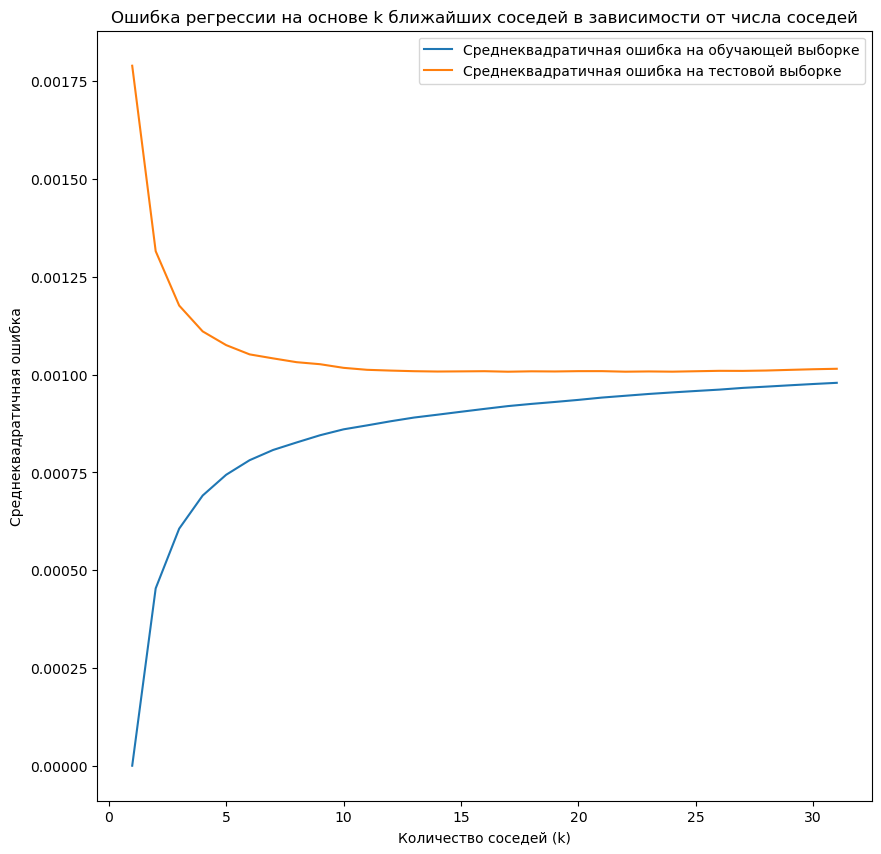

Оптимальное количество соседей: 17
Среднеквадратичная ошибка при оптимальном количестве соседей: 0.0010071908898434685


In [23]:
train_err = []
test_err = []
neigh_range = range(1, 32)

for k in neigh_range:
    model_kneigh = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)

    train_err.append(mean_squared_error(y_train, model_kneigh.predict(X_train)))
    test_err.append(mean_squared_error(y_test, model_kneigh.predict(X_test)))

plt.figure(figsize=(10, 10))
plt.plot(neigh_range, train_err, label="Среднеквадратичная ошибка на обучающей выборке")
plt.plot(neigh_range, test_err, label="Среднеквадратичная ошибка на тестовой выборке")
plt.xlabel("Количество соседей (k)")
plt.ylabel("Среднеквадратичная ошибка")
plt.legend()
plt.title("Ошибка регрессии на основе k ближайших соседей в зависимости от числа соседей")
plt.show()

optimal_k = neigh_range[test_err.index(min(test_err))]
print("Оптимальное количество соседей:", optimal_k)
print("Среднеквадратичная ошибка при оптимальном количестве соседей:", min(test_err))

## **10. Запустить другие регрессоры**

In [30]:
# Ridge
from sklearn.linear_model import Ridge

model_ridge = Ridge().fit(X_train, y_train)

y_pred_train_ridge = model_ridge.predict(X_train)
y_pred_test_ridge = model_ridge.predict(X_test)

print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (Ridge-регрессия, обучающая выборка, без учёта текста):")
print(mean_squared_error(y_train, y_pred_train_ridge))
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (Ridge-регрессия, тестовая выборка, без учёта текста):")
print(mean_squared_error(y_test, y_pred_test_ridge))

Среднеквадратичная ошибка для предсказания "полезности" обзора (Ridge-регрессия, обучающая выборка, без учёта текста):
0.001238289663566262
Среднеквадратичная ошибка для предсказания "полезности" обзора (Ridge-регрессия, тестовая выборка, без учёта текста):
0.0012189370670785387


In [31]:
# Support Vector Machine
from sklearn.svm import SVR

model_svmr = SVR().fit(X_train, y_train)

y_pred_train_svmr = model_svmr.predict(X_train)
y_pred_test_svmr = model_svmr.predict(X_test)

print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (машина опорных векторов, обучающая выборка, без учёта текста):")
print(mean_squared_error(y_train, y_pred_train_svmr))
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (машина опорных векторов, тестовая выборка, без учёта текста):")
print(mean_squared_error(y_test, y_pred_test_svmr))

Среднеквадратичная ошибка для предсказания "полезности" обзора (машина опорных векторов, обучающая выборка, без учёта текста):
0.002918216663702245
Среднеквадратичная ошибка для предсказания "полезности" обзора (машина опорных векторов, тестовая выборка, без учёта текста):
0.0028979402706973095


In [32]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor

model_sgdr = SGDRegressor().fit(X_train, y_train)

y_pred_train_sgdr = model_sgdr.predict(X_train)
y_pred_test_sgdr = model_sgdr.predict(X_test)

print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (стохастический градиентный спуск, обучающая выборка, без учёта текста):")
print(mean_squared_error(y_train, y_pred_train_sgdr))
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (стохастический градиентный спуск, тестовая выборка, без учёта текста):")
print(mean_squared_error(y_test, y_pred_test_sgdr))

Среднеквадратичная ошибка для предсказания "полезности" обзора (стохастический градиентный спуск, обучающая выборка, без учёта текста):
0.0012542133341497525
Среднеквадратичная ошибка для предсказания "полезности" обзора (стохастический градиентный спуск, тестовая выборка, без учёта текста):
0.001237808593491431


In [35]:
# Ensamble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

r1 = KNeighborsRegressor(n_neighbors=3)
r2 = LinearRegression()
r3 = Ridge(alpha=1.0)
r4 = RandomForestRegressor(n_estimators=10, random_state=42)
r5 = SVR(kernel='rbf', epsilon=0.1, gamma='scale')
r6 = SGDRegressor(loss='huber', penalty='elasticnet', alpha=1.0, l1_ratio=0.5, learning_rate='optimal', random_state=42)

model_ensamble = VotingRegressor([['r1', r1], ['r2', r2], ['r3', r3], ['r4', r4], ['r5', r5], ['r6', r6]]).fit(X_train, y_train)

y_pred_train_ensamble = model_ensamble.predict(X_train)
y_pred_test_ensamble = model_ensamble.predict(X_test)

print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (ансамбль, обучающая выборка, без учёта текста):")
print(mean_squared_error(y_train, y_pred_train_ensamble))
print("Среднеквадратичная ошибка для предсказания \"полезности\" обзора (ансамбль, тестовая выборка, без учёта текста):")
print(mean_squared_error(y_test, y_pred_test_ensamble))

Среднеквадратичная ошибка для предсказания "полезности" обзора (ансамбль, обучающая выборка, без учёта текста):
0.0008872732780983815
Среднеквадратичная ошибка для предсказания "полезности" обзора (ансамбль, тестовая выборка, без учёта текста):
0.0011162282884696793


## **11. Сделать общие выводы**

    1) Из датасета были убраны признаки, логически не влияющие на "полезность" обзора. Столбец с нулевыми значениями был удалён, поскольку соотношение ненулевых элементов к нулевым было крайне мало. Категориальный признак, соответствующий языку, был сведён к множеству бинарных столбцов. Текстовый признак (текст обзора) не учитывался в экспериментах - необходимо использовать иные подходы для его эффективного использования.
    2) В ходе экспериментов на уменьшенном варианте датасета было обнаружено оптимальное количество соседей для метода K ближайших соседей (в трактовке регрессии), при котором на тестовой выборке достигается среднеквадратическая ошибка чуть больше 10^(-3).
    3) Эксперименты с разными типами регрессоров показали, что на параметрах, взятых "из головы" на тестовой выборке лучше всего себя показал ансамбль из всех использованных регрессоров. Более низкой ошибки достиг только метод K ближайших соседей с оптимальным гиперпараметром. Специальный подбор оптимальных параметров для других регрессоров может позволить дополнительно улучшить результаты ансамбля.